<a href="https://colab.research.google.com/github/cikachuek/praktikum-AI/blob/main/yesikasinambela_2302050114_nlp_analisis_sentimen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# CELL 1: INSTALASI LIBRARY
# ==============================================================================
# Jalankan cell ini terlebih dahulu untuk menginstall library yang diperlukan
!pip install kaggle -q
!pip install sastrawi -q
!pip install wordcloud -q
print("✅ Instalasi library selesai!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 7.3 MB/s eta 0:00:00
✅ Instalasi library selesai!


In [ ]:
# CELL 2: IMPORT LIBRARY
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import warnings
warnings.filterwarnings('ignore')
# Library NLP
import nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab', quiet=True)
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
# Library Sastrawi (Bahasa Indonesia)
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
# Library Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Library Visualisasi
from wordcloud import WordCloud
# Set random seed
np.random.seed(42)
print("✅ Semua library berhasil diimport!")

✅ Semua library berhasil diimport!


In [ ]:
# ==============================================================================
# CELL 3: DOWNLOAD DATASET DARI KAGGLE
# ==============================================================================
# Cara 1: Upload file kaggle.json dari akun Kaggle Anda
# Cara 2: Gunakan link langsung (akan disediakan alternatif)

# --- OPSI A: Download dari Kaggle API ---
# Uncomment kode di bawah jika ingin menggunakan Kaggle API

# from google.colab import files
# files.upload()  # Upload file kaggle.json
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d alvinhanafie/dataset-for-indonesian-sentiment-analysis
# !unzip -o dataset-for-indonesian-sentiment-analysis.zip

# --- OPSI B: Download langsung dari URL alternatif ---
# Dataset sudah tersedia secara publik

import urllib.request
import os

# URL dataset (hosted di GitHub)
url = "https://raw.githubusercontent.com/rizalespe/Dataset-Sentimen-Analisis-Bahasa-Indonesia/master/dataset_tweet_sentimen_pilpres_2019.csv"

print("⏳ Mengunduh dataset...")
try:
    urllib.request.urlretrieve(url, "dataset_sentimen.csv")
    print("✅ Dataset berhasil diunduh!")
except:
    print("⚠️ Gagal mengunduh, membuat dataset contoh...")
    # Buat dataset contoh jika gagal download
    data_contoh = {
        'sentimen': ['positif']*20 + ['negatif']*20,
        'text': [
            'aplikasi ini sangat bagus dan mudah digunakan',
            'pelayanan yang memuaskan terima kasih',
            'produk berkualitas harga terjangkau',
            'sangat membantu sekali recommended',
            'pengiriman cepat barang sesuai deskripsi',
            'mantap banget puas belanja di sini',
            'kualitas terbaik tidak mengecewakan',
            'respon penjual cepat dan ramah',
            'barang original dan bagus banget',
            'sukses terus untuk tokonya',
            'saya sangat senang dengan layanan ini',
            'produk ini memenuhi ekspektasi saya',
            'harga murah kualitas tidak murahan',
            'pengalaman belanja yang menyenangkan',
            'akan order lagi di kemudian hari',
            'five stars untuk pelayanannya',
            'recommended seller terpercaya',
            'barang sampai dengan selamat',
            'packing aman dan rapi sekali',
            'terima kasih sudah amanah',
            'aplikasi sering error tidak bisa dibuka',
            'pelayanan sangat mengecewakan buruk sekali',
            'barang tidak sesuai deskripsi kecewa',
            'pengiriman lama sekali sudah seminggu',
            'kualitas jelek tidak worth it',
            'penjual tidak responsif sama sekali',
            'produk palsu bukan original',
            'rugi beli di sini menyesal',
            'barang rusak saat sampai',
            'tidak recommended jangan beli',
            'harga mahal tapi kualitas murahan',
            'penipuan barang tidak dikirim',
            'customer service tidak membantu',
            'refund susah sekali prosesnya',
            'aplikasi lemot dan sering crash',
            'bintang satu untuk pelayanan buruk',
            'kapok belanja di sini',
            'barang zonk tidak sesuai foto',
            'packing asal asalan barang penyok',
            'menyesal sudah order di sini'
        ]
    }
    df = pd.DataFrame(data_contoh)
    df.to_csv("dataset_sentimen.csv", index=False)
    print("✅ Dataset contoh berhasil dibuat!")


⏳ Mengunduh dataset...
⚠️ Gagal mengunduh, membuat dataset contoh...
✅ Dataset contoh berhasil dibuat!


In [ ]:
# CELL 4: LOAD DAN EKSPLORASI DATASET
# ==============================================================================

print("="*60)
print("LOAD DAN EKSPLORASI DATASET")
print("="*60)

# Load dataset
df = pd.read_csv("dataset_sentimen.csv", encoding='latin-1')

# Cek nama kolom
print("\n📋 Kolom dataset:", df.columns.tolist())

# Standardisasi nama kolom (sesuaikan dengan dataset yang digunakan)
# Rename kolom jika perlu
if 'Text Tweet' in df.columns:
    df = df.rename(columns={'Text Tweet': 'text', 'Sentiment': 'sentimen'})
elif 'tweet' in df.columns:
    df = df.rename(columns={'tweet': 'text', 'label': 'sentimen'})
elif 'content' in df.columns:
    df = df.rename(columns={'content': 'text', 'label': 'sentimen'})

# Pastikan kolom text dan sentimen ada
if 'text' not in df.columns:
    # Ambil kolom pertama sebagai text, kolom terakhir sebagai label
    cols = df.columns.tolist()
    df = df.rename(columns={cols[0]: 'sentimen', cols[-1]: 'text'})

print(f"\n📊 Ukuran dataset: {df.shape[0]} baris, {df.shape[1]} kolom")
print(f"\n📋 5 data pertama:")
print(df.head())

print(f"\n📋 Info dataset:")
print(df.info())

print(f"\n📋 Statistik deskriptif:")
print(df.describe())


LOAD DAN EKSPLORASI DATASET

📋 Kolom dataset: ['sentimen', 'text']

📊 Ukuran dataset: 40 baris, 2 kolom

📋 5 data pertama:
  sentimen                                           text
0  positif  aplikasi ini sangat bagus dan mudah digunakan
1  positif          pelayanan yang memuaskan terima kasih
2  positif            produk berkualitas harga terjangkau
3  positif             sangat membantu sekali recommended
4  positif       pengiriman cepat barang sesuai deskripsi

📋 Info dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentimen  40 non-null     object
 1   text      40 non-null     object
dtypes: object(2)
memory usage: 772.0+ bytes
None

📋 Statistik deskriptif:
       sentimen                                           text
count        40                                             40
unique        2                                          

In [ ]:
# ==============================================================================
# CELL 5: PEMBERSIHAN DATA
# ==============================================================================

print("\n" + "="*60)
print("PEMBERSIHAN DATA")
print("="*60)

# Cek missing values
print(f"\n🔍 Missing values:")
print(df.isnull().sum())

# Hapus missing values
df = df.dropna(subset=['text', 'sentimen'])
print(f"\n✅ Setelah hapus missing values: {len(df)} baris")

# Hapus duplikat
df = df.drop_duplicates(subset=['text'])
print(f"✅ Setelah hapus duplikat: {len(df)} baris")

# Reset index
df = df.reset_index(drop=True)

# Standardisasi label sentimen
df['sentimen'] = df['sentimen'].astype(str).str.lower().str.strip()

# Mapping label (jika ada variasi penulisan)
label_mapping = {
    'positive': 'positif',
    'negative': 'negatif',
    'neutral': 'netral',
    'pos': 'positif',
    'neg': 'negatif',
    'neu': 'netral',
    '1': 'positif',
    '0': 'negatif',
    '-1': 'negatif'
}
df['sentimen'] = df['sentimen'].replace(label_mapping)

# Filter hanya positif dan negatif (binary classification)
df = df[df['sentimen'].isin(['positif', 'negatif'])]
print(f"✅ Dataset final (positif & negatif): {len(df)} baris")

# Distribusi label
print(f"\n📊 Distribusi label:")
print(df['sentimen'].value_counts())



PEMBERSIHAN DATA

🔍 Missing values:
sentimen    0
text        0
dtype: int64

✅ Setelah hapus missing values: 40 baris
✅ Setelah hapus duplikat: 40 baris
✅ Dataset final (positif & negatif): 40 baris

📊 Distribusi label:
sentimen
positif    20
negatif    20
Name: count, dtype: int64


In [ ]:
# ==============================================================================
# CELL 6: PREPROCESSING TEXT
# ==============================================================================

print("\n" + "="*60)
print("PREPROCESSING TEXT")
print("="*60)

# Fungsi Cleaning Text
def clean_text(text):
    """Membersihkan teks dari karakter tidak diperlukan"""
    if not isinstance(text, str):
        return ""

    # Lowercase
    text = text.lower()

    # Hapus mention, hashtag, URL
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'http\S+|www\S+', '', text)

    # Hapus angka
    text = re.sub(r'\d+', '', text)

    # Hapus tanda baca
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Hapus extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Fungsi untuk mengganti slang words
slang_dict = {
    'gak': 'tidak', 'ga': 'tidak', 'gk': 'tidak', 'ngga': 'tidak',
    'nggak': 'tidak', 'kagak': 'tidak', 'tdk': 'tidak',
    'yg': 'yang', 'dgn': 'dengan', 'utk': 'untuk', 'kpd': 'kepada',
    'krn': 'karena', 'dr': 'dari', 'pd': 'pada', 'dlm': 'dalam',
    'blm': 'belum', 'sdh': 'sudah', 'udh': 'sudah', 'udah': 'sudah',
    'bgt': 'banget', 'bngt': 'banget', 'bener': 'benar',
    'emg': 'memang', 'emang': 'memang', 'dmn': 'dimana',
    'gmn': 'bagaimana', 'gimana': 'bagaimana', 'gmana': 'bagaimana',
    'gitu': 'begitu', 'gini': 'begini', 'gt': 'begitu',
    'sm': 'sama', 'sma': 'sama', 'aja': 'saja', 'aj': 'saja',
    'bs': 'bisa', 'bsa': 'bisa', 'hrs': 'harus',
    'lg': 'lagi', 'lgi': 'lagi', 'skrg': 'sekarang',
    'org': 'orang', 'ornag': 'orang', 'orng': 'orang',
    'gw': 'saya', 'gue': 'saya', 'gua': 'saya', 'w': 'saya',
    'lu': 'kamu', 'lo': 'kamu', 'lw': 'kamu', 'u': 'kamu',
    'km': 'kamu', 'kmu': 'kamu', 'sy': 'saya', 'ak': 'saya',
    'tp': 'tapi', 'tpi': 'tapi', 'jg': 'juga', 'jga': 'juga',
    'trs': 'terus', 'trus': 'terus', 'trz': 'terus',
    'mksh': 'terima kasih', 'makasih': 'terima kasih', 'thx': 'terima kasih',
    'ok': 'oke', 'okey': 'oke', 'okay': 'oke',
    'pls': 'tolong', 'pliss': 'tolong', 'plz': 'tolong',
    'mantap': 'bagus', 'mantul': 'bagus', 'mantab': 'bagus',
    'jelek': 'buruk', 'jlek': 'buruk', 'ancur': 'rusak',
    'lemot': 'lambat', 'lelet': 'lambat', 'lola': 'lambat',
    'worthit': 'sepadan', 'worth': 'sepadan'
}

def replace_slang(text):
    """Mengganti kata slang dengan kata baku"""
    words = text.split()
    return ' '.join([slang_dict.get(word, word) for word in words])

# Fungsi untuk menghapus stopwords
def remove_stopwords(text):
    """Menghapus stopwords Indonesia dan Inggris"""
    stop_words = set(stopwords.words('indonesian'))
    stop_words.update(stopwords.words('english'))
    # Tambahan stopwords custom
    custom_stops = {'yg', 'yang', 'dan', 'di', 'ke', 'dari', 'ini', 'itu',
                   'dengan', 'untuk', 'pada', 'adalah', 'nya', 'juga',
                   'saya', 'kamu', 'dia', 'mereka', 'kita', 'kami'}
    stop_words.update(custom_stops)

    words = text.split()
    return ' '.join([word for word in words if word not in stop_words and len(word) > 2])

# Fungsi Stemming (Bahasa Indonesia)
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stem_text(text):
    """Stemming kata ke bentuk dasar"""
    return stemmer.stem(text)

# Terapkan preprocessing
print("⏳ Memproses text...")

df['text_clean'] = df['text'].apply(clean_text)
print("   ✅ [1/4] Cleaning selesai")

df['text_clean'] = df['text_clean'].apply(replace_slang)
print("   ✅ [2/4] Slang replacement selesai")

df['text_clean'] = df['text_clean'].apply(remove_stopwords)
print("   ✅ [3/4] Stopwords removal selesai")

df['text_clean'] = df['text_clean'].apply(stem_text)
print("   ✅ [4/4] Stemming selesai")

print("\n✅ Preprocessing selesai!")

# Tampilkan contoh hasil
print("\n📋 Contoh hasil preprocessing:")
print("-"*60)
for i in range(min(3, len(df))):
    print(f"\nOriginal : {df['text'].iloc[i][:70]}...")
    print(f"Clean    : {df['text_clean'].iloc[i][:70]}...")


PREPROCESSING TEXT
⏳ Memproses text...
   ✅ [1/4] Cleaning selesai
   ✅ [2/4] Slang replacement selesai
   ✅ [3/4] Stopwords removal selesai
   ✅ [4/4] Stemming selesai

✅ Preprocessing selesai!

📋 Contoh hasil preprocessing:
------------------------------------------------------------

Original : aplikasi ini sangat bagus dan mudah digunakan...
Clean    : aplikasi bagus mudah...

Original : pelayanan yang memuaskan terima kasih...
Clean    : layan muas terima kasih...

Original : produk berkualitas harga terjangkau...
Clean    : produk kualitas harga jangkau...



VISUALISASI DATA


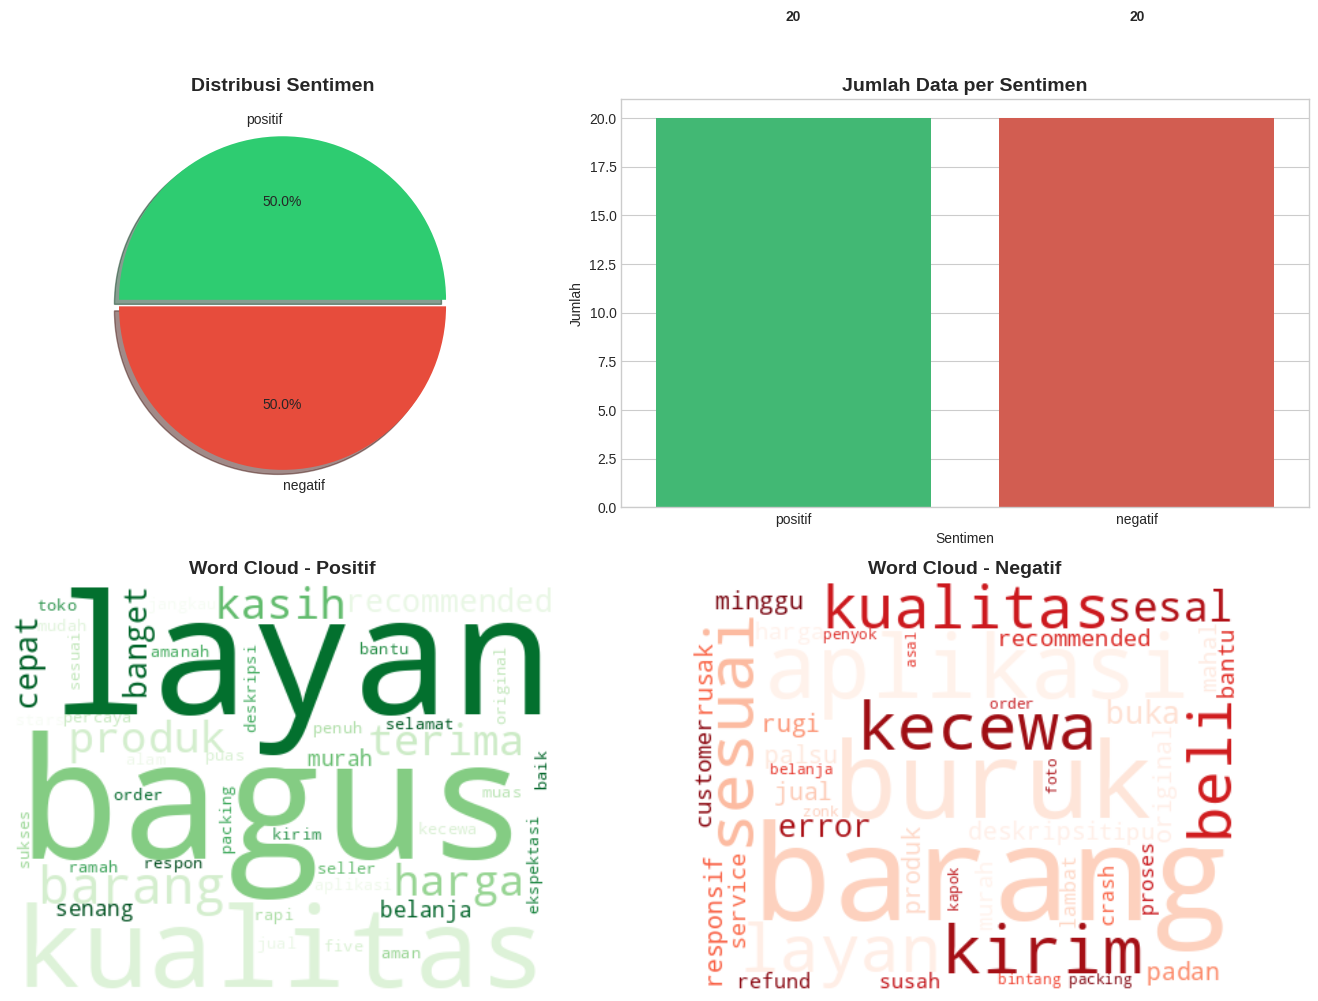


💾 Visualisasi disimpan ke 'visualisasi_sentimen.png'


In [ ]:
# ==============================================================================
# CELL 7: VISUALISASI DATA
# ==============================================================================

print("\n" + "="*60)
print("VISUALISASI DATA")
print("="*60)

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Distribusi Sentimen (Pie Chart)
colors = ['#2ecc71', '#e74c3c']
label_counts = df['sentimen'].value_counts()
axes[0, 0].pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%',
               colors=colors, explode=(0.02, 0.02), shadow=True)
axes[0, 0].set_title('Distribusi Sentimen', fontsize=14, fontweight='bold')

# 2. Distribusi Sentimen (Bar Chart)
sns.countplot(data=df, x='sentimen', ax=axes[0, 1],
              palette={'positif': '#2ecc71', 'negatif': '#e74c3c'})
axes[0, 1].set_title('Jumlah Data per Sentimen', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Sentimen')
axes[0, 1].set_ylabel('Jumlah')
for i, v in enumerate(label_counts.values):
    axes[0, 1].text(i, v + 5, str(v), ha='center', fontweight='bold')

# 3. Word Cloud - Positif
text_positif = ' '.join(df[df['sentimen'] == 'positif']['text_clean'].dropna())
if text_positif.strip():
    wc_pos = WordCloud(width=400, height=300, background_color='white',
                       colormap='Greens', max_words=50).generate(text_positif)
    axes[1, 0].imshow(wc_pos, interpolation='bilinear')
    axes[1, 0].axis('off')
    axes[1, 0].set_title('Word Cloud - Positif', fontsize=14, fontweight='bold')

# 4. Word Cloud - Negatif
text_negatif = ' '.join(df[df['sentimen'] == 'negatif']['text_clean'].dropna())
if text_negatif.strip():
    wc_neg = WordCloud(width=400, height=300, background_color='white',
                       colormap='Reds', max_words=50).generate(text_negatif)
    axes[1, 1].imshow(wc_neg, interpolation='bilinear')
    axes[1, 1].axis('off')
    axes[1, 1].set_title('Word Cloud - Negatif', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('visualisasi_sentimen.png', dpi=150, bbox_inches='tight')
plt.show()
print("\n💾 Visualisasi disimpan ke 'visualisasi_sentimen.png'")

In [ ]:
# ==============================================================================
# CELL 8: EKSTRAKSI FITUR DENGAN TF-IDF
# ==============================================================================

print("\n" + "="*60)
print("EKSTRAKSI FITUR DENGAN TF-IDF")
print("="*60)

# Pisahkan fitur dan label
X = df['text_clean']
y = df['sentimen']

# Ekstraksi fitur dengan TF-IDF
tfidf = TfidfVectorizer(max_features=1000, min_df=2, max_df=0.9, ngram_range=(1, 2))
X_tfidf = tfidf.fit_transform(X)

print(f"\n📊 Dimensi fitur TF-IDF: {X_tfidf.shape}")
print(f"   - Jumlah dokumen: {X_tfidf.shape[0]}")
print(f"   - Jumlah fitur: {X_tfidf.shape[1]}")

# Tampilkan 20 fitur teratas
feature_names = tfidf.get_feature_names_out()
print(f"\n📋 20 Fitur teratas:")
print(feature_names[:20])


EKSTRAKSI FITUR DENGAN TF-IDF

📊 Dimensi fitur TF-IDF: (40, 32)
   - Jumlah dokumen: 40
   - Jumlah fitur: 32

📋 20 Fitur teratas:
['aplikasi' 'bagus' 'bagus banget' 'banget' 'bantu' 'barang'
 'barang sesuai' 'belanja' 'beli' 'buruk' 'cepat' 'deskripsi' 'harga'
 'jual' 'kasih' 'kecewa' 'kirim' 'kualitas' 'kualitas murah' 'layan']


In [ ]:
# ==============================================================================
# CELL 9: SPLIT DATA TRAINING DAN TESTING
# ==============================================================================

print("\n" + "="*60)
print("SPLIT DATA TRAINING DAN TESTING")
print("="*60)

# Split data (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n📊 Pembagian data:")
print(f"   - Data Training: {X_train.shape[0]} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"   - Data Testing : {X_test.shape[0]} ({X_test.shape[0]/len(X)*100:.1f}%)")

print(f"\n📊 Distribusi label Training:")
print(pd.Series(y_train).value_counts())

print(f"\n📊 Distribusi label Testing:")
print(pd.Series(y_test).value_counts())


SPLIT DATA TRAINING DAN TESTING

📊 Pembagian data:
   - Data Training: 32 (80.0%)
   - Data Testing : 8 (20.0%)

📊 Distribusi label Training:
sentimen
negatif    16
positif    16
Name: count, dtype: int64

📊 Distribusi label Testing:
sentimen
negatif    4
positif    4
Name: count, dtype: int64


In [ ]:
# ==============================================================================
# CELL 10: TRAINING DAN EVALUASI MODEL
# ==============================================================================

print("\n" + "="*60)
print("TRAINING DAN EVALUASI MODEL")
print("="*60)

# Dictionary untuk menyimpan model dan hasil
models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='linear', random_state=42)
}

results = []

# Training dan evaluasi setiap model
for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"🤖 Model: {name}")
    print('='*50)

    # Training
    model.fit(X_train, y_train)

    # Prediksi
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Hitung akurasi
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)

    print(f"\n📊 Akurasi Training: {acc_train*100:.2f}%")
    print(f"📊 Akurasi Testing : {acc_test*100:.2f}%")

    # Classification Report
    print(f"\n📋 Classification Report (Testing):")
    print(classification_report(y_test, y_pred_test))

    # Simpan hasil
    results.append({
        'Model': name,
        'Akurasi Training': acc_train,
        'Akurasi Testing': acc_test
    })


TRAINING DAN EVALUASI MODEL

🤖 Model: Naive Bayes

📊 Akurasi Training: 90.62%
📊 Akurasi Testing : 50.00%

📋 Classification Report (Testing):
              precision    recall  f1-score   support

     negatif       0.50      0.50      0.50         4
     positif       0.50      0.50      0.50         4

    accuracy                           0.50         8
   macro avg       0.50      0.50      0.50         8
weighted avg       0.50      0.50      0.50         8


🤖 Model: Logistic Regression

📊 Akurasi Training: 90.62%
📊 Akurasi Testing : 62.50%

📋 Classification Report (Testing):
              precision    recall  f1-score   support

     negatif       0.67      0.50      0.57         4
     positif       0.60      0.75      0.67         4

    accuracy                           0.62         8
   macro avg       0.63      0.62      0.62         8
weighted avg       0.63      0.62      0.62         8


🤖 Model: Random Forest

📊 Akurasi Training: 96.88%
📊 Akurasi Testing : 50.00%

📋 C


PERBANDINGAN PERFORMA MODEL

📊 Ranking Model berdasarkan Akurasi Testing:
--------------------------------------------------
   Logistic Regression       : 62.50%
   Naive Bayes               : 50.00%
   Random Forest             : 50.00%
   SVM                       : 50.00%


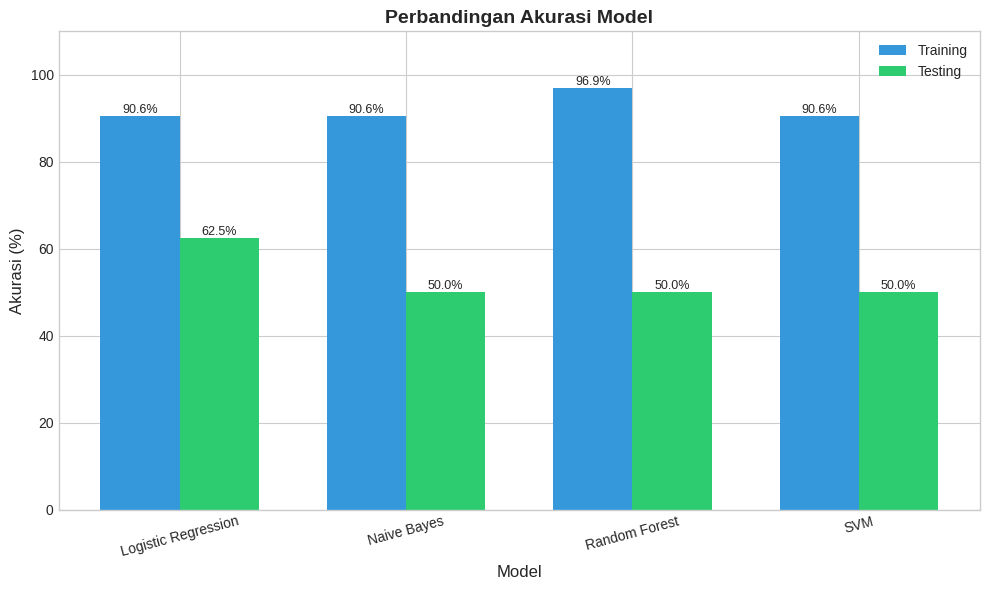


💾 Grafik disimpan ke 'perbandingan_model.png'

🏆 MODEL TERBAIK: Logistic Regression dengan akurasi 62.50%


In [ ]:
# ==============================================================================
# CELL 11: PERBANDINGAN MODEL
# ==============================================================================

print("\n" + "="*60)
print("PERBANDINGAN PERFORMA MODEL")
print("="*60)

# Buat DataFrame hasil
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Akurasi Testing', ascending=False)

print("\n📊 Ranking Model berdasarkan Akurasi Testing:")
print("-"*50)
for i, row in results_df.iterrows():
    print(f"   {row['Model']:25} : {row['Akurasi Testing']*100:.2f}%")

# Visualisasi perbandingan
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(results_df))
width = 0.35

bars1 = ax.bar(x - width/2, results_df['Akurasi Training']*100, width,
               label='Training', color='#3498db')
bars2 = ax.bar(x + width/2, results_df['Akurasi Testing']*100, width,
               label='Testing', color='#2ecc71')

ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Akurasi (%)', fontsize=12)
ax.set_title('Perbandingan Akurasi Model', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(results_df['Model'], rotation=15)
ax.legend()
ax.set_ylim([0, 110])

# Tambahkan nilai di atas bar
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%', ha='center', va='bottom', fontsize=9)
for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('perbandingan_model.png', dpi=150, bbox_inches='tight')
plt.show()
print("\n💾 Grafik disimpan ke 'perbandingan_model.png'")

# Model terbaik
best_model_name = results_df.iloc[0]['Model']
best_accuracy = results_df.iloc[0]['Akurasi Testing']
print(f"\n🏆 MODEL TERBAIK: {best_model_name} dengan akurasi {best_accuracy*100:.2f}%")



CONFUSION MATRIX - MODEL TERBAIK


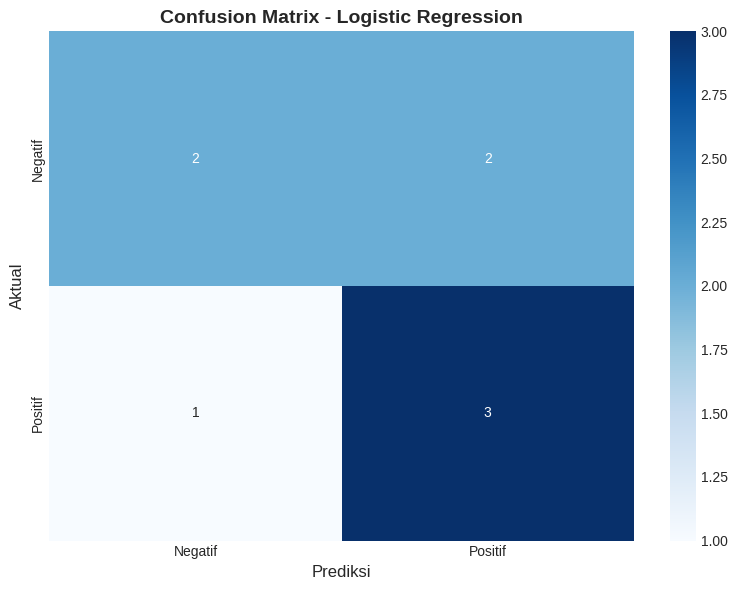


💾 Confusion Matrix disimpan ke 'confusion_matrix.png'


In [ ]:
# ==============================================================================
# CELL 12: CONFUSION MATRIX MODEL TERBAIK
# ==============================================================================

print("\n" + "="*60)
print("CONFUSION MATRIX - MODEL TERBAIK")
print("="*60)

# Gunakan model terbaik
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negatif', 'Positif'],
            yticklabels=['Negatif', 'Positif'])
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.xlabel('Prediksi', fontsize=12)
plt.ylabel('Aktual', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()
print("\n💾 Confusion Matrix disimpan ke 'confusion_matrix.png'")


In [ ]:
# ==============================================================================
# CELL 13: PREDIKSI TEKS BARU
# ==============================================================================

print("\n" + "="*60)
print("PREDIKSI TEKS BARU")
print("="*60)

def predict_sentiment(text, model, vectorizer):
    """
    Fungsi untuk memprediksi sentimen teks baru
    """
    # Preprocessing
    text_clean = clean_text(text)
    text_clean = replace_slang(text_clean)
    text_clean = remove_stopwords(text_clean)
    text_clean = stem_text(text_clean)

    # Vektorisasi
    text_vector = vectorizer.transform([text_clean])

    # Prediksi
    prediction = model.predict(text_vector)[0]

    return prediction

# Contoh prediksi
contoh_teks = [
    "Aplikasi ini sangat bagus dan mudah digunakan, recommended!",
    "Pelayanan sangat buruk dan mengecewakan, tidak akan beli lagi",
    "Harga lumayan terjangkau, kualitas standar saja",
    "Mantap banget! Pengiriman cepat, barang sesuai deskripsi",
    "Kecewa berat, barang tidak sesuai foto, penjual tidak responsif"
]

print("\n🔮 Hasil Prediksi:")
print("-"*60)
for teks in contoh_teks:
    hasil = predict_sentiment(teks, best_model, tfidf)
    emoji = "✅" if hasil == "positif" else "❌"
    print(f"\n📝 Teks: {teks[:50]}...")
    print(f"   {emoji} Sentimen: {hasil.upper()}")


PREDIKSI TEKS BARU

🔮 Hasil Prediksi:
------------------------------------------------------------

📝 Teks: Aplikasi ini sangat bagus dan mudah digunakan, rec...
   ✅ Sentimen: POSITIF

📝 Teks: Pelayanan sangat buruk dan mengecewakan, tidak aka...
   ❌ Sentimen: NEGATIF

📝 Teks: Harga lumayan terjangkau, kualitas standar saja...
   ✅ Sentimen: POSITIF

📝 Teks: Mantap banget! Pengiriman cepat, barang sesuai des...
   ✅ Sentimen: POSITIF

📝 Teks: Kecewa berat, barang tidak sesuai foto, penjual ti...
   ❌ Sentimen: NEGATIF


In [ ]:
# ==============================================================================
# CELL 14: SIMPAN MODEL
# ==============================================================================

print("\n" + "="*60)
print("SIMPAN MODEL")
print("="*60)

import pickle

# Simpan model terbaik
with open('model_sentimen.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Simpan vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

print("✅ Model disimpan ke 'model_sentimen.pkl'")
print("✅ Vectorizer disimpan ke 'tfidf_vectorizer.pkl'")

# Simpan hasil ke CSV
df.to_csv('dataset_hasil_preprocessing.csv', index=False)
results_df.to_csv('hasil_evaluasi_model.csv', index=False)

print("✅ Dataset hasil preprocessing disimpan ke 'dataset_hasil_preprocessing.csv'")
print("✅ Hasil evaluasi disimpan ke 'hasil_evaluasi_model.csv'")


SIMPAN MODEL
✅ Model disimpan ke 'model_sentimen.pkl'
✅ Vectorizer disimpan ke 'tfidf_vectorizer.pkl'
✅ Dataset hasil preprocessing disimpan ke 'dataset_hasil_preprocessing.csv'
✅ Hasil evaluasi disimpan ke 'hasil_evaluasi_model.csv'


In [ ]:
# ==============================================================================
# CELL 15: KESIMPULAN
# ==============================================================================

print("\n" + "="*60)
print("📊 KESIMPULAN")
print("="*60)

print(f"""
┌─────────────────────────────────────────────────────────────┐
│                    RINGKASAN PROYEK                          │
├─────────────────────────────────────────────────────────────┤
│  📁 Dataset        : {len(df):,} data                              │
│  📊 Fitur TF-IDF   : {X_tfidf.shape[1]:,} fitur                           │
│  🔀 Split Ratio    : 80% Training, 20% Testing              │
├─────────────────────────────────────────────────────────────┤
│  🏆 Model Terbaik  : {best_model_name:25}         │
│  📈 Akurasi        : {best_accuracy*100:.2f}%                              │
├─────────────────────────────────────────────────────────────┤
│  💾 File Output:                                            │
│     - model_sentimen.pkl                                    │
│     - tfidf_vectorizer.pkl                                  │
│     - dataset_hasil_preprocessing.csv                       │
│     - hasil_evaluasi_model.csv                              │
│     - visualisasi_sentimen.png                              │
│     - perbandingan_model.png                                │
│     - confusion_matrix.png                                  │
└─────────────────────────────────────────────────────────────┘
""")

print("\n✅ PROYEK SENTIMENT ANALYSIS SELESAI!")
print("="*60)


📊 KESIMPULAN

┌─────────────────────────────────────────────────────────────┐
│                    RINGKASAN PROYEK                          │
├─────────────────────────────────────────────────────────────┤
│  📁 Dataset        : 40 data                              │
│  📊 Fitur TF-IDF   : 32 fitur                           │
│  🔀 Split Ratio    : 80% Training, 20% Testing              │
├─────────────────────────────────────────────────────────────┤
│  🏆 Model Terbaik  : Logistic Regression               │
│  📈 Akurasi        : 62.50%                              │
├─────────────────────────────────────────────────────────────┤
│  💾 File Output:                                            │
│     - model_sentimen.pkl                                    │
│     - tfidf_vectorizer.pkl                                  │
│     - dataset_hasil_preprocessing.csv                       │
│     - hasil_evaluasi_model.csv                              │
│     - visualisasi_sentimen.png            